In [52]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch
import os
import re
import librosa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load experiment data
xls = pd.ExcelFile('data/experiment_data.xlsx')
experiment_data = {}
# Iterate through sheet names and load into the dictionary
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    sheet_name = sheet_name.lower().rstrip('-ru')
    experiment_data[sheet_name] = df
    
def load_audio_files(language):

    experiment_data_l = experiment_data[language]
    print(language)
    audio_directory = f"data/audio_split/{language}"

    # Check if the directory exists
    if not os.path.exists(audio_directory):
        print(f"Error: Directory '{audio_directory}' not found.")
        return None

    # Get a list of audio files in the directory
    audio_files = [os.path.join(audio_directory, file) for file in os.listdir(audio_directory) if file.endswith(".wav")]
    # Extract numerical parts from filenames (assuming the format is 'XX_YY.wav')
    file_numbers = [re.search(r'(\d+)_(\d+)\.wav', file).groups() for file in audio_files]

    # Sort audio files based on the numerical parts before and after the underscore
    sorted_audio_files = sorted(zip(audio_files, file_numbers), key=lambda x: (int(x[1][0]), int(x[1][1])))

    # Load audio files using librosa
    audio_data = {}
    all_data = {}
    for audio_file, (file_number_before, file_number_after) in sorted_audio_files:
        audio_clip, sr = librosa.load(audio_file, sr=16000)
        # Append audio clips to a list for the specific file number
        if file_number_before not in audio_data:
            audio_data[file_number_before] = []
        audio_data[file_number_before].append(audio_clip)

    # Concatenate audio clips for each file number
    for file_number_before, clips_list in audio_data.items():
        audio_data[file_number_before] = np.concatenate(clips_list)

    for index, row in experiment_data_l.iterrows():
        row_number = index
        sentence_l2 = row['sentence l2']
        row_number = row_number+1
        row_number= str(row_number)
        if len(row_number) < 2:
            row_number = '0'+row_number
        all_data[row_number] = (sentence_l2, audio_data[row_number])

    
    return all_data


# Example usage for loading audio for different languages
languages = ["be", "bg", "cs", "uk", "pl"]
audio_data = dict()
for language in languages:
    audio_data[language] = load_audio_files(language)
 

be
bg
cs
uk
pl


In [48]:
# We'll need IPython.display's Audio widget
audio_clip, sr = librosa.load('data/audio_split/be/49_2.wav', sr=16000)
from IPython.display import Audio
Audio(data=audio_data['be']['46'][1], rate=16000)

In [25]:
# Preprocess the datasets and calculate surprisal values
MODEL_ID = "bond005/wav2vec2-large-ru-golos"
processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)

print('hello')
model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)
print('hello2')

hello


Some weights of the model checkpoint at bond005/wav2vec2-large-ru-golos were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at bond005/wav2vec2-large-ru-golos and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN thi

hello2


In [50]:
def get_surprisal(audio_data):
    surprisal_values = {}
    for file_number, (sentence, audio_clip) in audio_data.items():
        # Convert the audio clip to torch tensor
        input_values = processor(np.array(audio_clip), return_tensors="pt", padding="longest", sampling_rate=16000).input_values
        
        # Get logits from the model
        logits = model(input_values).logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
        # Get the predicted class (argmax along the last dimension)
        predicted_class = torch.argmax(logits, dim=-1)
        
        # Calculate surprisal as negative log probability of the correct class
        surprisal_value = -torch.log(probabilities[0, predicted_class[0]]).mean().item()
        surprisal_values[file_number] = (sentence, surprisal_value)
        
    return surprisal_values

# Save surprisal values for each language
for language in languages:
    print(language)
    audio_data_language = audio_data[language]
    surprisal_values_language = get_surprisal(audio_data_language)

    # Create directory if it doesn't exist
    save_directory = f"data/surprisal_wav2vec/{language}"
    os.makedirs(save_directory, exist_ok=True)

    # Save data to CSV
    df = pd.DataFrame(list(surprisal_values_language.items()), columns=['audio_number', 'data'])
    df[['sentence', 'surprisal_value']] = pd.DataFrame(df['data'].tolist(), index=df.index)
    df.drop(['data'], axis=1, inplace=True)
    df.to_csv(os.path.join(save_directory, 'surprisal_data.csv'), index=False)

be
bg
cs
uk
pl


be
bg
cs
uk
pl


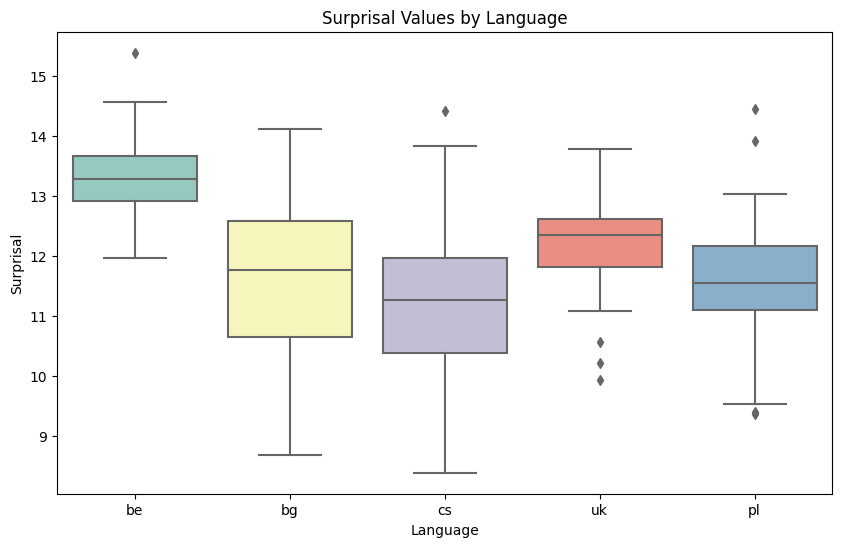

In [65]:

# Function to load surprisal data from CSV
def load_surprisal_data(language):
    file_path = f"data/surprisal_wav2vec/{language}/surprisal_data.csv"
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        print(f"Error: File '{file_path}' not found.")
        return None

# Load and plot surprisal data for each language
surprisal_values = dict()
for language in languages:
    print(language)
    surprisal_values[language] = load_surprisal_data(language)
    
# Assuming you have a dictionary of surprisal values by language
# where surprisal_values[language] is a dictionary with file_number as keys and surprisal values as values.

# Create a list to store data for plotting
plot_data = []

for language, values in surprisal_values.items():
    for surprisal_value in values['surprisal_value']:
        plot_data.append({'Language': language, 'Surprisal': surprisal_value})

# Convert the list to a DataFrame
plot_df = pd.DataFrame(plot_data)

# Create a boxplot with different colors for each language
plt.figure(figsize=(10, 6))
sns.boxplot(x='Language', y='Surprisal', data=plot_df, palette="Set3")
plt.title('Surprisal Values by Language')
plt.show()


In [66]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec